In [41]:
"""
Common Imports and Utilities for Augmentation Pipelines
======================================================

This module consolidates imports used across the dataset augmentation codebase.

"""

# -------------------------
# Standard library
# -------------------------
import os
import json
import glob
import random
from pathlib import Path
from typing import List, Tuple, Dict, Optional

# -------------------------
# Third-party libraries
# -------------------------
import numpy as np
import cv2                    # OpenCV (BGR images, geometry)
import albumentations as A    # Photometric & (optionally) geometric transforms

# -------------------------
# Type aliases (clarify intent in function signatures)
# -------------------------
Keypoint        = Tuple[float, float, int]          # (x, y, v) with COCO-style visibility
KeypointsXYV    = List[Keypoint]                    # list of 20 triples by convention
BBoxInt         = Tuple[int, int, int, int]         # (xmin, ymin, xmax, ymax)
ImageArray      = np.ndarray                        # H×W×C, dtype=uint8 (BGR in OpenCV)

# -------------------------
# Reproducibility helpers
# -------------------------
def set_seeds(seed: int) -> None:
    """
    Seed Python's and NumPy's RNGs for reproducible experiments.

    Parameters
    ----------
    seed : int
        The global random seed to use.
    """
    random.seed(seed)
    np.random.seed(seed)


# -------------------------
# Environment transparency
# -------------------------
def report_env(prefix: str = "[ENV]") -> None:
    """
    Print library versions relevant to the augmentation pipeline.

    Parameters
    ----------
    prefix : str
        String prefix for log lines.
    """
    # Versions (guarded if a library lacks a __version__ attribute)
    np_ver  = getattr(np, "__version__", "unknown")
    cv2_ver = getattr(cv2, "__version__", "unknown")
    try:
        alb_ver = A.__version__  # albumentations defines __version__
    except Exception:
        alb_ver = "unknown"

    print(f"{prefix} numpy:          {np_ver}")
    print(f"{prefix} opencv-python:  {cv2_ver}")
    print(f"{prefix} albumentations: {alb_ver}")


# -------------------------
# Public API
# -------------------------
__all__ = [
    # third-party
    "np", "cv2", "A",
    # stdlib utilities
    "os", "json", "glob", "Path", "List", "Tuple", "Dict", "Optional",
    # types
    "Keypoint", "KeypointsXYV", "BBoxInt", "ImageArray",
    # helpers
    "set_seeds", "report_env",
]



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### **Ajuste seguro de rotación y traslación para evitar la pérdida de estructuras morfológicas en peces**

In [ ]:
# ============================
# PATH CONFIGURATION
# ============================
# Adjust these paths according to your actual Google Drive directory structure.

# Root directory containing the source fish images
IMAGES_ROOT = (
    "/content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/IMAGENES PECES/CAVFISH/Dataset_CavFish_SAM/Dataset_CavFish_12_2024/2016 Rio Bita"
)

# Path to COCO-style annotation file (20 keypoints per fish)
ANNOT_JSON = (
    "/content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/Anotaciones manuales/Anotaciones 04-06-2025/fisk_20kpts_2025.json"
)

# Output directory for augmented images and updated annotation JSON
OUT_DIR = (
    "/content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation"
)

In [60]:
"""
Fish Morphometrics — Keypoint Definitions and Augmentation Protocol
===================================================================

This file documents (i) the semantic meaning of keypoint (KP) index pairs used
for derived linear measures, and (ii) the data augmentation operations and their
probabilities, together with implementation details that preserve annotation
consistency.

--------------------------------------------------------------------
A) Keypoint (KP) pairs and associated morphometric traits
--------------------------------------------------------------------
Indices refer to the 0-based keypoint order in the dataset.

# Left/Right pair used for horizontal flip (to swap semantic indices)
(0, 1): Snout ↔ Caudal fin base (standard length)    [USED FOR L/R SWAP ON H-FLIP]

# Vertical (upper/lower) or left/right pairs for derived traits
(2, 3),   # Anterior insertion (dorsal fin) ↔ Anterior insertion (pelvic fin) = (Body depth)
(4, 5),   # Dorsal-most (upper) part vertically to the eye ↔ Ventral-most (upper) part vertically to the eye  = (Head depth)
(6, 7),  # Dorsal insertion caudal fin ↔ Ventral insertion caudal fin = (Caudal peduncle depth)
 (8, 9),  # Dorsal-most (upper) part vertically to the caudal fin ↔ Ventral-most (upper) part vertically to the caudal fin = (Caudal fin depth)
(10,11),  # Dorsal-most (upper) part of eye ↔ Ventral-most (lower) part of eye = (Eye diameter)
(12,3),  # Center (centroid) of eye ↔ Anterior insertion of the pelvic fin = (Eye position)
(0,3),  # Snout ↔ Anterior insertion (pelvic fin) = (Mouth position)
(0,13),  # Snout ↔ Corner of the mouth = (Maxilary jaw length)
(14,15),  # Anterior insertion pectoral fin ↔ Distal part the longest ray of the pectoral end = (Pectoral fin legth)
(14,3),  # Anterior insertion pectoral fin ↔ Anterior insertion (pelvic fin) = (Pectoral fin position)
(0,16),  # Snout ↔ Most dorsal point of operculum, which is the posterior-most part of the head = (Head length)
(2,17),  # Anterior insertion (dorsal fin) ↔ Posterior insertion of dorsal fin = (Dorsal-fin length)
(18,19),  # Anterior insertion of the anal fin ↔ Posterior insertion of the anal fin = (Anal-fin length)

--------------------------------------------------------------------
B) Data augmentation protocol and probabilities
--------------------------------------------------------------------
Horizontal flip + L/R swap
- Horizontal flip: p = 0.5 (applied to 50% of images).
- Left/Right swap: applied iff a flip occurred (to preserve semantics).

Geometric safety (no keypoint clipping)
- Rotation: sampled from U(-45°, +45°); if any visible KP would leave the frame,
  the absolute angle is halved repeatedly until all visible KPs remain inside
  (geometric "backoff"; may end at 0° if needed).
- Translation: sampled independently along x/y up to ±10% of width/height;
  if any visible KP would leave the frame, (dx, dy) are halved repeatedly until
  all visible KPs remain inside (may end at (0, 0) if needed).

Photometric augmentation (Albumentations; does not move keypoints)
- Gaussian noise: p = 0.25
- Color jitter (brightness/contrast/saturation/hue): p = 0.7

Local GridMask around selected KPs
- For each target KP, a local GridMask region is applied independently with
  probability GRIDMASK_PROB (here 0.8). With 4 targets and p=0.8, the number of
  masked regions per image follows Binomial(n=4, p=0.8); the most likely counts
  are 3 or 4 (~41% each), 1 is rare (~2.6%), and 0 is very unlikely (~0.16%).

Visibility manipulation and location jitter
- Probabilistic occlusion (set v=0) by difficulty:
    HARD_KP: p=0.8; EASY_KP: p=0.5; OTHER: p=0.1.
- Jitter applied only to visible KPs (v>0) with p_apply=0.8:
    HARD_KP: integer offset in [-10, +10] px on both axes.
    EASY_KP: integer offset in [-m, +m] px, m∈{3,4,5}.
    OTHER:   integer offset in [-3, +3] px.

All operations preserve the KP format (x, y, v) where v∈{0,1,2} encodes
visibility (0: hidden/ignored; 1: labeled but not visible; 2: visible).
"""

from __future__ import annotations

import glob
import json
import os
import random
from pathlib import Path
from typing import List, Tuple, Dict

import cv2
import numpy as np
import albumentations as A

# -------------------------
# Reproducibility and sampling
# -------------------------
RANDOM_SEED: int = 42
N_SAMPLES: int = 5

# -------------------------
# Left/Right keypoint pairs (for semantic swap on horizontal flip)
# -------------------------
# (0, 1): Snout ↔ Caudal fin base (standard length)
KP_LR_PAIRS: List[Tuple[int, int]] = [(0, 1)]

# -------------------------
# Keypoint difficulty partitions (for jitter and probabilistic occlusion)
# -------------------------
HARD_KP: Tuple[int, ...] = (0, 1, 8, 9 ,13, 14, 15, 16, 17, 19 )   # larger jitter radius (±10 px)
EASY_KP: Tuple[int, ...] = (
    2, 3, 4, 5, 6, 7, 10, 11, 12,  18
)  # small jitter radius (±3..5 px)

# Probabilistic occlusion (set v=0) by difficulty
HIDE_PROB_HARD: float = 0.7
HIDE_PROB_EASY: float = 0.3
HIDE_PROB_OTHER: float = 0.1

# -------------------------
# GridMask configuration
# -------------------------
GRIDMASK_TARGETS: Tuple[int, ...] = (0, 1, 8, 9 ,13, 14, 15, 16, 17, 19)
GRIDMASK_PROB: float = 0.4  # independent probability per target KP

# =============================================================================
# I/O UTILITIES
# =============================================================================

def load_coco_annotations(json_path: str):
    """
    Load a COCO-style annotation file.

    Returns
    -------
    images : Dict[int, dict]
        Mapping from image_id -> image metadata.
    by_file : Dict[str, int]
        Mapping from basename(file_name) -> image_id.
    anns_by_img : Dict[int, dict]
        Mapping from image_id -> its single annotation (assumed 20 keypoints).
    coco : dict
        Raw COCO dictionary.
    """
    with open(json_path, "r") as f:
        coco = json.load(f)

    images = {img["id"]: img for img in coco["images"]}
    by_file = {Path(img["file_name"]).name: img["id"] for img in coco["images"]}

    # One annotation per image (20 KPs) is assumed.
    anns_by_img: Dict[int, dict] = {}
    for ann in coco["annotations"]:
        anns_by_img[ann["image_id"]] = ann

    return images, by_file, anns_by_img, coco


def list_images_recursive(root: str) -> List[str]:
    """
    Recursively list image files under `root`.
    """
    exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG", "*.JPEG")
    files: List[str] = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return files


def ensure_dir(path: str) -> None:
    """
    Create a directory if it does not exist.
    """
    os.makedirs(path, exist_ok=True)

# =============================================================================
# PHOTOMETRIC AUGMENTATION (does not move keypoints)
# =============================================================================

train_color_only = A.Compose(
    [
        A.GaussNoise(var_limit=(5.0, 25.0), p=0.25),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.7),
    ],
    keypoint_params=A.KeypointParams(
        format="xy", remove_invisible=False, label_fields=["keypoints_vis"]
    ),
)

# =============================================================================
# LOCAL GRIDMASK AROUND SELECTED KEYPOINTS
# =============================================================================

def apply_local_gridmask(
    image: np.ndarray,
    keypoints_xy: List[Tuple[float, float]],
    kp_indices_to_occlude: Tuple[int, ...],
    box_size: int = 96,
    grid_d: int = 15,
    ratio: float = 0.4,
    prob: float = 0.2,
    angle_deg: float = 0.0,
) -> np.ndarray:
    """
    Apply a local GridMask pattern centered at selected KPs with independent probability.

    Parameters
    ----------
    image : np.ndarray
        Input BGR image.
    keypoints_xy : list of (x, y)
        Current keypoint coordinates (visibility handled elsewhere).
    kp_indices_to_occlude : tuple of int
        KP indices to consider for local masking.
    box_size : int
        Square window size around each KP.
    grid_d : int
        Grid period (pixels) in both axes.
    ratio : float
        Black-band fraction per grid cell (0..1).
    prob : float
        Independent probability of applying the mask at each KP.
    angle_deg : float
        Optional in-plane rotation of the grid pattern.

    Returns
    -------
    np.ndarray
        Image with zeroed-out pixels in masked bands within the local windows.
    """
    h, w = image.shape[:2]
    out = image.copy()

    for idx in kp_indices_to_occlude:
        if not (0 <= idx < len(keypoints_xy)):
            continue
        if random.random() > prob:
            continue

        cx, cy = int(keypoints_xy[idx][0]), int(keypoints_xy[idx][1])
        half = box_size // 2
        x1, y1 = max(0, cx - half), max(0, cy - half)
        x2, y2 = min(w, cx + half), min(h, cy + half)

        region = out[y1:y2, x1:x2]
        rh, rw = region.shape[:2]
        if rh <= 1 or rw <= 1:
            continue

        # Build grid mask
        mask = np.ones((rh, rw), dtype=np.uint8)
        band_w = lambda d: int(max(1, ratio * d))

        for y in range(0, rh, grid_d):
            mask[y : min(rh, y + band_w(grid_d)), :] = 0
        for x in range(0, rw, grid_d):
            mask[:, x : min(rw, x + band_w(grid_d))] = 0

        if angle_deg != 0:
            M = cv2.getRotationMatrix2D((rw / 2, rh / 2), angle_deg, 1.0)
            mask = cv2.warpAffine(mask, M, (rw, rh), flags=cv2.INTER_NEAREST, borderValue=1)

        region[mask == 0] = 0
        out[y1:y2, x1:x2] = region

    return out

# =============================================================================
# KEYPOINT JITTER (only for visible KPs, v>0)
# =============================================================================

def jitter_keypoints_xyv(
    keypoints_xyv: List[Tuple[float, float, int]],
    img_w: int,
    img_h: int,
    hard_indices: Tuple[int, ...] = HARD_KP,
    easy_indices: Tuple[int, ...] = EASY_KP,
    p_apply: float = 0.8,
) -> List[Tuple[float, float, int]]:
    """
    Randomly perturb visible keypoints with probability p_apply.
    Jitter magnitude depends on KP difficulty class.
    """
    out: List[Tuple[float, float, int]] = []
    hard_set, easy_set = set(hard_indices), set(easy_indices)

    for i, (x, y, v) in enumerate(keypoints_xyv):
        if v > 0 and random.random() < p_apply:
            if i in hard_set:
                dx = random.randint(-10, 10)
                dy = random.randint(-10, 10)
            elif i in easy_set:
                mag = random.randint(3, 5)
                dx = random.randint(-mag, mag)
                dy = random.randint(-mag, mag)
            else:
                dx = random.randint(-3, 3)
                dy = random.randint(-3, 3)

            x = float(np.clip(x + dx, 0, img_w - 1))
            y = float(np.clip(y + dy, 0, img_h - 1))

        out.append((float(x), float(y), int(v)))

    return out

# =============================================================================
# PROBABILISTIC OCCLUSION (set v=0) BY DIFFICULTY
# =============================================================================

def hide_keypoints_xyv_by_difficulty(
    keypoints_xyv: List[Tuple[float, float, int]],
    hard_indices: Tuple[int, ...] = HARD_KP,
    easy_indices: Tuple[int, ...] = EASY_KP,
    p_hard: float = HIDE_PROB_HARD,
    p_easy: float = HIDE_PROB_EASY,
    p_other: float = HIDE_PROB_OTHER,
    rng: random.Random | None = None,
) -> List[Tuple[float, float, int]]:
    """
    Stochastically set visibility v=0 by KP difficulty class.
    """
    rng = rng or random
    hard_set, easy_set = set(hard_indices), set(easy_indices)
    out: List[Tuple[float, float, int]] = []

    for i, (x, y, v) in enumerate(keypoints_xyv):
        if i in hard_set:
            p = p_hard
        elif i in easy_set:
            p = p_easy
        else:
            p = p_other

        out.append((float(x), float(y), 0 if rng.random() < p else int(v)))

    return out

# =============================================================================
# GEOMETRY — BACKOFF TO PREVENT KEYPOINT CLIPPING
# =============================================================================

def kps_inside(
    kps_xyv: List[Tuple[float, float, int]],
    w: int,
    h: int,
    margin: int = 0,
) -> bool:
    """
    Return True iff all visible keypoints (v>0) lie within [margin, w-1-margin] × [margin, h-1-margin].
    """
    xmin, ymin = margin, margin
    xmax, ymax = w - 1 - margin, h - 1 - margin

    for (x, y, v) in kps_xyv:
        if v > 0 and not (xmin <= x <= xmax and ymin <= y <= ymax):
            return False
    return True


def transform_kps_affine(
    kps_xyv: List[Tuple[float, float, int]],
    M: np.ndarray,
) -> List[Tuple[float, float, int]]:
    """
    Apply a 2×3 affine transform M to keypoints (visibility is preserved).
    """
    out: List[Tuple[float, float, int]] = []
    for (x, y, v) in kps_xyv:
        X = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        Y = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        out.append((float(X), float(Y), int(v)))
    return out


def apply_affine_same_size(
    image: np.ndarray,
    M: np.ndarray,
    border_value: Tuple[int, int, int] = (0, 0, 0),
) -> np.ndarray:
    """
    Warp the image using a 2×3 affine matrix M, preserving the original canvas size.
    """
    h, w = image.shape[:2]
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=border_value)


def hflip_with_swap_backoff(
    image: np.ndarray,
    keypoints_xyv: List[Tuple[float, float, int]],
    kp_lr_pairs: List[Tuple[int, int]] | None = None,
    p: float = 0.5,
    swap: bool = False,
):
    """
    Horizontal flip with probability p, updating x→(w-1)-x.
    If `swap` is True, swap given L/R keypoint indices to preserve semantics.
    A sanity check verifies that no visible KP leaves the canvas.
    """
    if random.random() > p:
        return image, list(keypoints_xyv), False

    img = cv2.flip(image, 1)
    h, w = img.shape[:2]

    kps = [(float((w - 1) - x), float(y), int(v)) for (x, y, v) in keypoints_xyv]

    if swap and kp_lr_pairs:
        kps = list(kps)
        for li, ri in kp_lr_pairs:
            if 0 <= li < len(kps) and 0 <= ri < len(kps):
                kps[li], kps[ri] = kps[ri], kps[li]

    if not kps_inside(kps, w, h, margin=0):
        # Unlikely if original KPs were valid; fall back to no flip.
        return image, list(keypoints_xyv), False

    return img, kps, True


def safe_rotate_backoff(
    image: np.ndarray,
    kps_xyv: List[Tuple[float, float, int]],
    angle_deg: float,
    max_iters: int = 10,
    border_value: Tuple[int, int, int] = (0, 0, 0),
):
    """
    In-place rotation around the image center by `angle_deg`. If any visible KP would leave
    the canvas, iteratively halve the absolute angle (backoff) until all remain inside (or 0°).
    """
    h, w = image.shape[:2]
    cX, cY = w / 2.0, h / 2.0
    a = float(angle_deg)

    for _ in range(max_iters + 1):
        M = cv2.getRotationMatrix2D((cX, cY), a, 1.0)
        kps_t = transform_kps_affine(kps_xyv, M)
        if kps_inside(kps_t, w, h, margin=0):
            return apply_affine_same_size(image, M, border_value), kps_t, a
        a *= 0.5  # reduce magnitude toward 0°

    # Could not find a safe angle; return original
    return image, list(kps_xyv), 0.0


def safe_translate_backoff(
    image: np.ndarray,
    kps_xyv: List[Tuple[float, float, int]],
    dx: float,
    dy: float,
    max_iters: int = 10,
    border_value: Tuple[int, int, int] = (0, 0, 0),
):
    """
    In-place translation by (dx, dy). If any visible KP would leave the canvas,
    iteratively halve (dx, dy) until all remain inside (or (0, 0)).
    """
    tx, ty = float(dx), float(dy)

    for _ in range(max_iters + 1):
        M = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
        kps_t = transform_kps_affine(kps_xyv, M)
        h, w = image.shape[:2]
        if kps_inside(kps_t, w, h, margin=0):
            return apply_affine_same_size(image, M, border_value), kps_t, tx, ty
        tx *= 0.5
        ty *= 0.5

    # Could not find a safe shift; return original
    return image, list(kps_xyv), 0.0, 0.0


# Convenience wrapper preserving the original function name/signature
def hflip_with_swap(
    image, keypoints_xyv, kp_lr_pairs=None, p: float = 0.5, swap: bool = False
):
    return hflip_with_swap_backoff(image, keypoints_xyv, kp_lr_pairs=kp_lr_pairs, p=p, swap=swap)

# =============================================================================
# SINGLE-SAMPLE AUGMENTATION PIPELINE
# =============================================================================

def augment_sample(
    image_bgr: np.ndarray,
    keypoints_xyv: List[Tuple[float, float, int]],
):
    """
    Full augmentation for one (image, keypoints) pair.

    Order of operations
    -------------------
    1) Horizontal flip + L/R swap (p=0.5), with sanity check.
    2) Safe rotation (backoff) + safe translation (backoff) — geometry only.
    3) Photometric transforms (noise, color) — Albumentations; preserves KPs.
    4) Local GridMask around selected KPs (independent per target).
    5) Probabilistic occlusion (v=0) by difficulty, then jitter on visible KPs.

    Returns
    -------
    img_aug : np.ndarray
        Augmented BGR image.
    kps_aug_xyv : list of (x, y, v)
        Augmented keypoints with preserved visibility semantics.
    """
    # 1) Horizontal flip (swap semantics if requested)
    img, kps, _did_flip = hflip_with_swap(
        image_bgr, keypoints_xyv, KP_LR_PAIRS, p=0.5, swap=True
    )

    # 2) Geometry: rotation and translation with backoff guarantees
    angle = random.uniform(-45.0, 45.0)
    img, kps, _angle_used = safe_rotate_backoff(img, kps, angle_deg=angle, max_iters=10, border_value=(0, 0, 0))

    h0, w0 = img.shape[:2]
    max_dx, max_dy = int(round(0.10 * w0)), int(round(0.10 * h0))
    dx = random.randint(-max_dx, max_dx)
    dy = random.randint(-max_dy, max_dy)
    img, kps, _dx_used, _dy_used = safe_translate_backoff(img, kps, dx=dx, dy=dy, max_iters=10, border_value=(0, 0, 0))

    # 3) Photometric transforms (Albumentations)
    keypoints_xy = [(x, y) for (x, y, v) in kps]
    keypoints_vis = [int(v) for (_, _, v) in kps]
    transformed = train_color_only(image=img, keypoints=keypoints_xy, keypoints_vis=keypoints_vis)
    img_aug = transformed["image"]
    kps_aug_xyv = [(float(x), float(y), int(v)) for (x, y), v in zip(transformed["keypoints"], transformed["keypoints_vis"])]

    # 4) Local GridMask near selected KPs
    img_aug = apply_local_gridmask(
        img_aug,
        keypoints_xy=[(x, y) for (x, y, v) in kps_aug_xyv],
        kp_indices_to_occlude=GRIDMASK_TARGETS,
        box_size=96,
        grid_d=6,
        ratio=0.2,
        prob=GRIDMASK_PROB,
        angle_deg=0.0,
    )

    # 5) Probabilistic occlusion by difficulty, then jitter on visible KPs
    h, w = img_aug.shape[:2]
    kps_aug_xyv = hide_keypoints_xyv_by_difficulty(kps_aug_xyv)
    kps_aug_xyv = jitter_keypoints_xyv(kps_aug_xyv, img_w=w, img_h=h)

    return img_aug, kps_aug_xyv


/tmp/ipython-input-375011915.py:170: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 25.0), p=0.25),


In [ ]:
import glob
import json
import os
import random
from pathlib import Path
from typing import List, Tuple, Dict

import cv2
import numpy as np
import albumentations as A

# =============================================================================
# MAIN PIPELINE — COCO I/O, Sampling, Augmentation, and Export
# =============================================================================

def main() -> None:
    """
    End-to-end pipeline for sampling input images, applying the augmentation
    routine to each image/annotation pair, and writing the augmented dataset
    (images + COCO annotations) to disk.

    Assumptions
    -----------
    - A COCO-style JSON file is available at `ANNOT_JSON` with one annotation per
      image and exactly 20 keypoints per instance (shape: [x1,y1,v1,...,x20,y20,v20]).
    - Input images are discoverable under `IMAGES_ROOT` (recursive search).
    - `augment_sample(img, keypoints)` returns (augmented_image, augmented_keypoints_xyv),
      preserving the (x, y, v) keypoint format and visibility semantics.

    Reproducibility
    ---------------
    - Python's `random` and NumPy's RNGs are seeded with `RANDOM_SEED`.
    - A fixed-size subset of images (N_SAMPLES) is selected deterministically
      after seeding.

    Outputs
    -------
    - Augmented images are written to `OUT_DIR/<basename>_aug.jpg`.
    - A COCO JSON file aggregating augmented annotations is written to:
      `OUT_DIR/annotations_aug2.json`.

    Notes
    -----
    - Images with missing or malformed annotations are skipped with a warning.
    - If an input image cannot be read from disk, it is skipped with a warning.
    """
    ensure_dir(OUT_DIR)

    from __future__ import annotations

# -------------------------
# Reproducibility and sampling
# -------------------------
RANDOM_SEED: int = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
N_SAMPLES: int = 5

# -------------------------
# Left/Right keypoint pairs (for semantic swap on horizontal flip)
# FIX: head↔tail is not L/R; keep empty and don't swap on flip.
# -------------------------
KP_LR_PAIRS: List[Tuple[int, int]] = []

# -------------------------
# Keypoint difficulty partitions (for jitter and probabilistic occlusion)
# -------------------------
HARD_KP: Tuple[int, ...] = (0, 1, 8, 9, 13, 14, 15, 16, 17, 19)
EASY_KP: Tuple[int, ...] = (2, 3, 4, 5, 6, 7, 10, 11, 12, 18)

# Probabilistic occlusion (set v=0) by difficulty
# FIX: make occlusion rates realistic/conservative.
HIDE_PROB_HARD: float = 0.25
HIDE_PROB_EASY: float = 0.08
HIDE_PROB_OTHER: float = 0.03

# -------------------------
# GridMask configuration
# (same mechanism, just gentler probability)
# -------------------------
GRIDMASK_TARGETS: Tuple[int, ...] = (0, 1, 8, 9, 13, 14, 15, 16, 17, 19)
GRIDMASK_PROB: float = 0.25  # FIX: lower than 0.4 to avoid over-occluding

# =============================================================================
# I/O UTILITIES
# =============================================================================

def load_coco_annotations(json_path: str):
    """
    Load a COCO-style annotation file.

    Returns
    -------
    images : Dict[int, dict]
        Mapping from image_id -> image metadata.
    by_file : Dict[str, int]
        Mapping from basename(file_name) -> image_id.
    anns_by_img : Dict[int, dict]
        Mapping from image_id -> its single annotation (assumed 20 keypoints).
    coco : dict
        Raw COCO dictionary.
    """
    with open(json_path, "r") as f:
        coco = json.load(f)

    images = {img["id"]: img for img in coco["images"]}
    by_file = {Path(img["file_name"]).name: img["id"] for img in coco["images"]}

    anns_by_img: Dict[int, dict] = {}
    for ann in coco["annotations"]:
        anns_by_img[ann["image_id"]] = ann

    return images, by_file, anns_by_img, coco


def list_images_recursive(root: str) -> List[str]:
    """
    Recursively list image files under `root`.
    """
    exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG", "*.JPEG")
    files: List[str] = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return files


def ensure_dir(path: str) -> None:
    """
    Create a directory if it does not exist.
    """
    os.makedirs(path, exist_ok=True)

# =============================================================================
# PHOTOMETRIC AUGMENTATION (does not move keypoints)
# (Same ops; safer magnitudes/probabilities)
# =============================================================================

train_color_only = A.Compose(
    [
        # FIX: keep noise but within a moderate band
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.25),

        # FIX: reduce hue and keep brightness/contrast/saturation bounded
        A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.2, hue=0.03, p=0.7),
    ],
    keypoint_params=A.KeypointParams(
        format="xy", remove_invisible=False, label_fields=["keypoints_vis"]
    ),
)

# =============================================================================
# LOCAL GRIDMASK AROUND SELECTED KEYPOINTS
# (Mechanism unchanged; gentler probability)
# =============================================================================

def apply_local_gridmask(
    image: np.ndarray,
    keypoints_xy: List[Tuple[float, float]],
    kp_indices_to_occlude: Tuple[int, ...],
    box_size: int = 96,
    grid_d: int = 15,
    ratio: float = 0.4,
    prob: float = GRIDMASK_PROB,
    angle_deg: float = 0.0,
) -> np.ndarray:
    """
    Apply a local GridMask pattern centered at selected KPs with independent probability.
    """
    h, w = image.shape[:2]
    out = image.copy()

    for idx in kp_indices_to_occlude:
        if not (0 <= idx < len(keypoints_xy)):
            continue
        if random.random() > prob:
            continue

        cx, cy = int(keypoints_xy[idx][0]), int(keypoints_xy[idx][1])
        half = box_size // 2
        x1, y1 = max(0, cx - half), max(0, cy - half)
        x2, y2 = min(w, cx + half), min(h, cy + half)

        region = out[y1:y2, x1:x2]
        rh, rw = region.shape[:2]
        if rh <= 1 or rw <= 1:
            continue

        # Build grid mask
        mask = np.ones((rh, rw), dtype=np.uint8)
        band_w = lambda d: int(max(1, ratio * d))

        for y in range(0, rh, grid_d):
            mask[y : min(rh, y + band_w(grid_d)), :] = 0
        for x in range(0, rw, grid_d):
            mask[:, x : min(rw, x + band_w(grid_d))] = 0

        if angle_deg != 0:
            M = cv2.getRotationMatrix2D((rw / 2, rh / 2), angle_deg, 1.0)
            mask = cv2.warpAffine(mask, M, (rw, rh), flags=cv2.INTER_NEAREST, borderValue=1)

        region[mask == 0] = 0
        out[y1:y2, x1:x2] = region

    return out

# =============================================================================
# KEYPOINT JITTER (only for visible KPs, v>0)
# (Same mechanism; gentler p and magnitudes)
# =============================================================================

def jitter_keypoints_xyv(
    keypoints_xyv: List[Tuple[float, float, int]],
    img_w: int,
    img_h: int,
    hard_indices: Tuple[int, ...] = HARD_KP,
    easy_indices: Tuple[int, ...] = EASY_KP,
    p_apply: float = 0.4,  # FIX: lower than 0.8
) -> List[Tuple[float, float, int]]:
    """
    Randomly perturb visible keypoints with probability p_apply.
    Jitter magnitude depends on KP difficulty class.
    """
    out: List[Tuple[float, float, int]] = []
    hard_set, easy_set = set(hard_indices), set(easy_indices)

    for i, (x, y, v) in enumerate(keypoints_xyv):
        if v > 0 and random.random() < p_apply:
            if i in hard_set:
                # FIX: gentler than ±10 px
                dx = random.randint(-6, 6)
                dy = random.randint(-6, 6)
            elif i in easy_set:
                mag = random.randint(2, 3)
                dx = random.randint(-mag, mag)
                dy = random.randint(-mag, mag)
            else:
                dx = random.randint(-2, 2)
                dy = random.randint(-2, 2)

            x = float(np.clip(x + dx, 0, img_w - 1))
            y = float(np.clip(y + dy, 0, img_h - 1))

        out.append((float(x), float(y), int(v)))

    return out

# =============================================================================
# PROBABILISTIC OCCLUSION (set v=0) BY DIFFICULTY
# (Same function; new default probs)
# =============================================================================

def hide_keypoints_xyv_by_difficulty(
    keypoints_xyv: List[Tuple[float, float, int]],
    hard_indices: Tuple[int, ...] = HARD_KP,
    easy_indices: Tuple[int, ...] = EASY_KP,
    p_hard: float = HIDE_PROB_HARD,
    p_easy: float = HIDE_PROB_EASY,
    p_other: float = HIDE_PROB_OTHER,
    rng: random.Random | None = None,
) -> List[Tuple[float, float, int]]:
    """
    Stochastically set visibility v=0 by KP difficulty class.
    """
    rng = rng or random
    hard_set, easy_set = set(hard_indices), set(easy_indices)
    out: List[Tuple[float, float, int]] = []

    for i, (x, y, v) in enumerate(keypoints_xyv):
        if i in hard_set:
            p = p_hard
        elif i in easy_set:
            p = p_easy
        else:
            p = p_other

        out.append((float(x), float(y), 0 if rng.random() < p else int(v)))

    return out

# =============================================================================
# GEOMETRY — BACKOFF TO PREVENT KEYPOINT CLIPPING
# (Same logic; rotation range softened)
# =============================================================================

def kps_inside(
    kps_xyv: List[Tuple[float, float, int]],
    w: int,
    h: int,
    margin: int = 0,
) -> bool:
    """
    Return True iff all visible keypoints (v>0) lie within [margin, w-1-margin] × [margin, h-1-margin].
    """
    xmin, ymin = margin, margin
    xmax, ymax = w - 1 - margin, h - 1 - margin

    for (x, y, v) in kps_xyv:
        if v > 0 and not (xmin <= x <= xmax and ymin <= y <= ymax):
            return False
    return True


def transform_kps_affine(
    kps_xyv: List[Tuple[float, float, int]],
    M: np.ndarray,
) -> List[Tuple[float, float, int]]:
    """
    Apply a 2×3 affine transform M to keypoints (visibility is preserved).
    """
    out: List[Tuple[float, float, int]] = []
    for (x, y, v) in kps_xyv:
        X = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        Y = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        out.append((float(X), float(Y), int(v)))
    return out


def apply_affine_same_size(
    image: np.ndarray,
    M: np.ndarray,
    border_value: Tuple[int, int, int] = (0, 0, 0),
) -> np.ndarray:
    """
    Warp the image using a 2×3 affine matrix M, preserving the original canvas size.
    """
    h, w = image.shape[:2]
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=border_value)


def hflip_with_swap_backoff(
    image: np.ndarray,
    keypoints_xyv: List[Tuple[float, float, int]],
    kp_lr_pairs: List[Tuple[int, int]] | None = None,
    p: float = 0.5,
    swap: bool = False,
):
    """
    Horizontal flip with probability p, updating x→(w-1)-x.
    If `swap` is True, swap given L/R keypoint indices to preserve semantics.
    A sanity check verifies that no visible KP leaves the canvas.
    """
    if random.random() > p:
        return image, list(keypoints_xyv), False

    img = cv2.flip(image, 1)
    h, w = img.shape[:2]

    kps = [(float((w - 1) - x), float(y), int(v)) for (x, y, v) in keypoints_xyv]

    if swap and kp_lr_pairs:
        kps = list(kps)
        for li, ri in kp_lr_pairs:
            if 0 <= li < len(kps) and 0 <= ri < len(kps):
                kps[li], kps[ri] = kps[ri], kps[li]

    if not kps_inside(kps, w, h, margin=0):
        # Unlikely if original KPs were valid; fall back to no flip.
        return image, list(keypoints_xyv), False

    return img, kps, True


def safe_rotate_backoff(
    image: np.ndarray,
    kps_xyv: List[Tuple[float, float, int]],
    angle_deg: float,
    max_iters: int = 10,
    border_value: Tuple[int, int, int] = (0, 0, 0),
):
    """
    In-place rotation around the image center by `angle_deg`. If any visible KP would leave
    the canvas, iteratively halve the absolute angle (backoff) until all remain inside (or 0°).
    """
    h, w = image.shape[:2]
    cX, cY = w / 2.0, h / 2.0
    a = float(angle_deg)

    for _ in range(max_iters + 1):
        M = cv2.getRotationMatrix2D((cX, cY), a, 1.0)
        kps_t = transform_kps_affine(kps_xyv, M)
        if kps_inside(kps_t, w, h, margin=0):
            return apply_affine_same_size(image, M, border_value), kps_t, a
        a *= 0.5  # reduce magnitude toward 0°

    # Could not find a safe angle; return original
    return image, list(kps_xyv), 0.0


def safe_translate_backoff(
    image: np.ndarray,
    kps_xyv: List[Tuple[float, float, int]],
    dx: float,
    dy: float,
    max_iters: int = 10,
    border_value: Tuple[int, int, int] = (0, 0, 0),
):
    """
    In-place translation by (dx, dy). If any visible KP would leave the canvas,
    iteratively halve (dx, dy) until all remain inside (or (0, 0)).
    """
    tx, ty = float(dx), float(dy)

    for _ in range(max_iters + 1):
        M = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
        kps_t = transform_kps_affine(kps_xyv, M)
        h, w = image.shape[:2]
        if kps_inside(kps_t, w, h, margin=0):
            return apply_affine_same_size(image, M, border_value), kps_t, tx, ty
        tx *= 0.5
        ty *= 0.5

    # Could not find a safe shift; return original
    return image, list(kps_xyv), 0.0, 0.0


# Convenience wrapper preserving the original function name/signature
def hflip_with_swap(
    image, keypoints_xyv, kp_lr_pairs=None, p: float = 0.5, swap: bool = False
):
    return hflip_with_swap_backoff(image, keypoints_xyv, kp_lr_pairs=kp_lr_pairs, p=p, swap=swap)

# =============================================================================
# SINGLE-SAMPLE AUGMENTATION PIPELINE
# =============================================================================

def augment_sample(
    image_bgr: np.ndarray,
    keypoints_xyv: List[Tuple[float, float, int]],
):
    """
    Full augmentation for one (image, keypoints) pair.

    Order of operations
    -------------------
    1) Horizontal flip (p=0.5), NO L/R swap unless true L/R pairs exist.
    2) Safe rotation (backoff) + safe translation (backoff) — geometry only.
    3) Photometric transforms (noise, color) — Albumentations; preserves KPs.
    4) Local GridMask around selected KPs (independent per target; gentler p).
    5) Probabilistic occlusion (v=0) by difficulty, then jitter on visible KPs.
    """
    # 1) Horizontal flip (no semantic swap for head↔tail)
    img, kps, _did_flip = hflip_with_swap(
        image_bgr, keypoints_xyv, KP_LR_PAIRS, p=0.5, swap=False
    )

    # 2) Geometry: rotation and translation with backoff guarantees
    # FIX: soften rotation range to reduce unrealistic poses and backoffs
    angle = random.uniform(-20.0, 20.0)
    img, kps, _angle_used = safe_rotate_backoff(img, kps, angle_deg=angle, max_iters=10, border_value=(0, 0, 0))

    h0, w0 = img.shape[:2]
    max_dx, max_dy = int(round(0.10 * w0)), int(round(0.10 * h0))
    dx = random.randint(-max_dx, max_dx)
    dy = random.randint(-max_dy, max_dy)
    img, kps, _dx_used, _dy_used = safe_translate_backoff(img, kps, dx=dx, dy=dy, max_iters=10, border_value=(0, 0, 0))

    # 3) Photometric transforms (Albumentations)
    keypoints_xy = [(x, y) for (x, y, v) in kps]
    keypoints_vis = [int(v) for (_, _, v) in kps]
    transformed = train_color_only(image=img, keypoints=keypoints_xy, keypoints_vis=keypoints_vis)
    img_aug = transformed["image"]
    kps_aug_xyv = [(float(x), float(y), int(v)) for (x, y), v in zip(transformed["keypoints"], transformed["keypoints_vis"])]

    # 4) Local GridMask near selected KPs (same op; gentler p)
    img_aug = apply_local_gridmask(
        img_aug,
        keypoints_xy=[(x, y) for (x, y, v) in kps_aug_xyv],
        kp_indices_to_occlude=GRIDMASK_TARGETS,
        box_size=96,
        grid_d=8,    # slightly denser grid is fine; mechanism unchanged
        ratio=0.25,  # milder stripe width
        prob=GRIDMASK_PROB,
        angle_deg=0.0,
    )

    # 5) Probabilistic occlusion by difficulty, then jitter on visible KPs
    h, w = img_aug.shape[:2]
    kps_aug_xyv = hide_keypoints_xyv_by_difficulty(kps_aug_xyv)  # uses gentler default probs
    kps_aug_xyv = jitter_keypoints_xyv(kps_aug_xyv, img_w=w, img_h=h)  # uses gentler p/mags

    return img_aug, kps_aug_xyv


[OK] Wrote augmented image: /content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation/IMG_0828-Editar_aug.jpg  |  visible KPs: 7/20
[OK] Wrote augmented image: /content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation/IMG_2159-Editar_aug.jpg  |  visible KPs: 9/20
[OK] Wrote augmented image: /content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation/IMG_5367-Editar_aug.jpg  |  visible KPs: 11/20
[OK] Wrote augmented image: /content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation/IMG_7052-Editar_aug.jpg  |  visible KPs: 8/20
[OK] Wrote augmented image: /content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation/IMG_8191-Editar_aug.jpg  |  visible KPs: 5/20
[OK] Wrote augmented COCO annotations: /content/d

/tmp/ipython-input-1924607266.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  KP_CMAP = plt.cm.get_cmap("tab20", N_KEYPOINTS)  # stable color map with 20 distinct colors


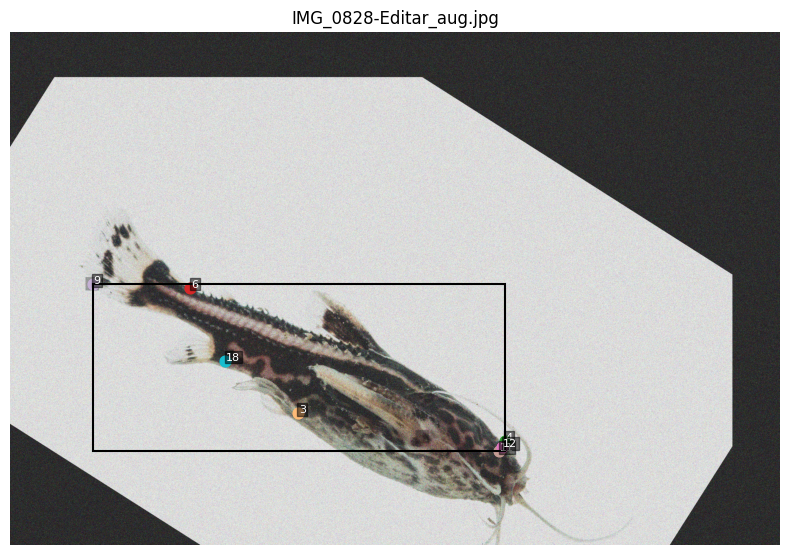

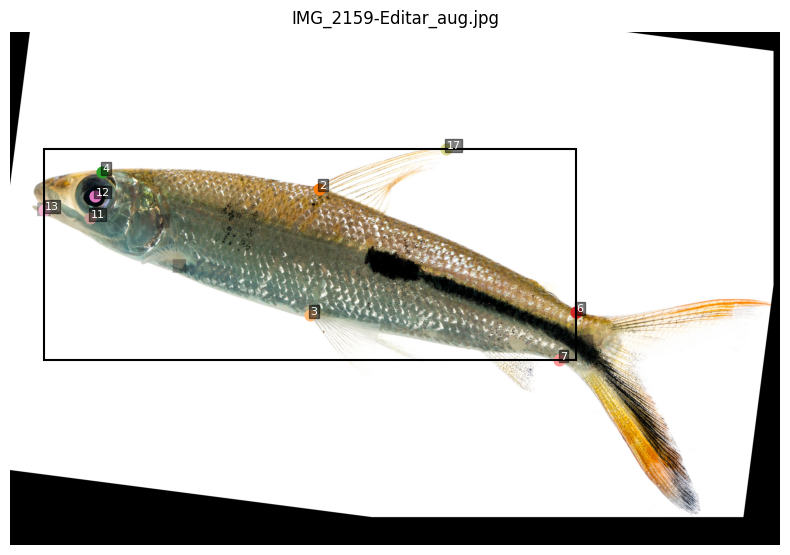

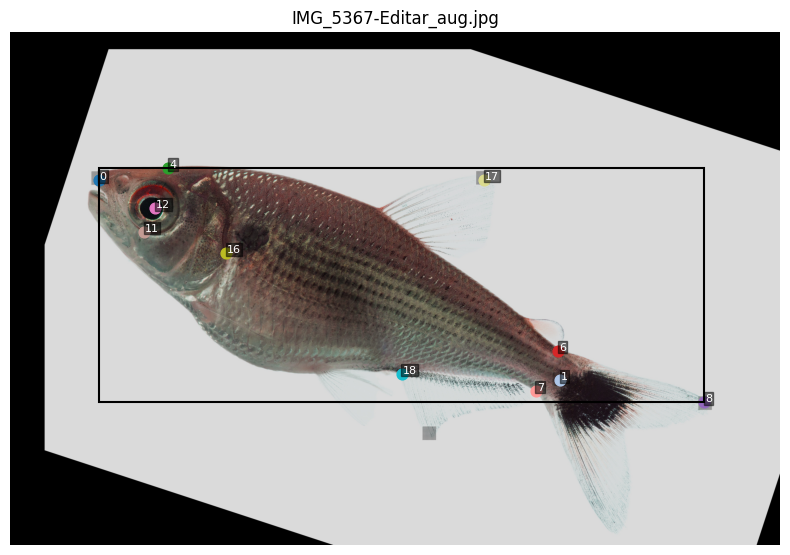

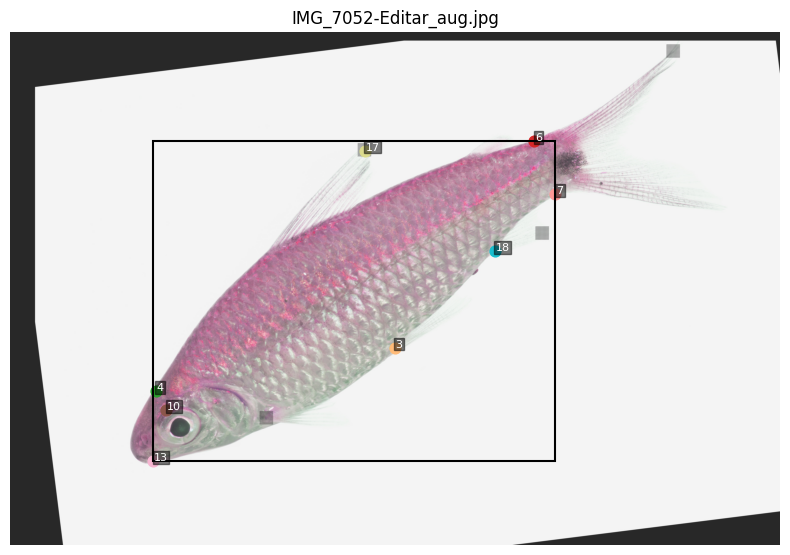

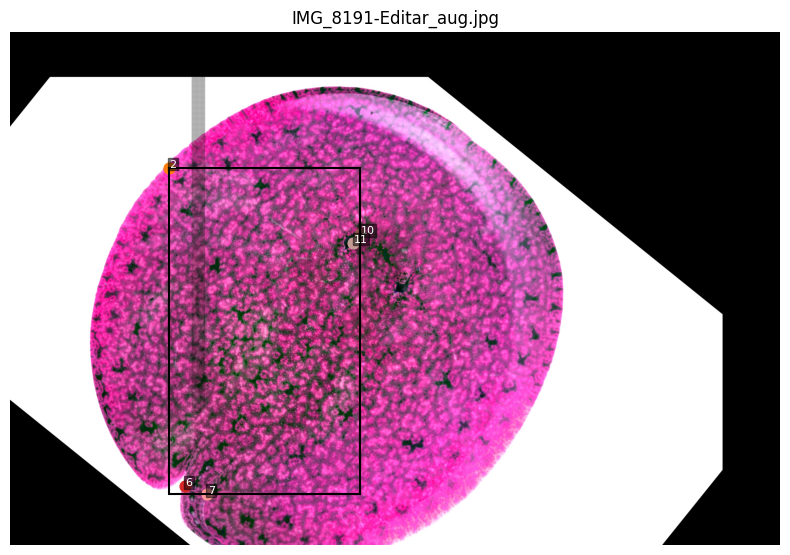

[OK] Visualization complete.


In [62]:
"""
Visualization of Augmented Keypoints on Images
=============================================

This script loads a COCO-style JSON file containing augmented annotations,
renders each augmented image, and overlays its keypoints. It is designed
for clarity and reproducibility in scientific reporting.

Key features
------------
- Robust I/O: explicit checks for missing files and malformed entries.
- Clear plotting: consistent colors (tab20) for KPs, numeric labels next to points.
- Minimal side effects: figures are closed after display to avoid memory bloat.

Assumptions
-----------
- The COCO JSON contains `images` and `annotations` with exactly 20 keypoints per instance,
  flattened as [x1, y1, v1, ..., x20, y20, v20].
- Images referenced by the JSON exist in `OUT_DIR`.

Usage
-----
Adjust OUT_DIR and ANNOT_JSON_OUT below, then run.
"""

from __future__ import annotations

import json
import os
from pathlib import Path
from typing import List, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Configuration (edit as needed)
# -------------------------
OUT_DIR = Path(
    "/content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation"
)
ANNOT_JSON_OUT = OUT_DIR / "annotations_aug.json"

# -------------------------
# Constants
# -------------------------
N_KEYPOINTS: int = 20
KP_CMAP = plt.cm.get_cmap("tab20", N_KEYPOINTS)  # stable color map with 20 distinct colors


# -------------------------
# Utilities
# -------------------------
def load_coco(path: Path) -> dict:
    """
    Load a COCO-style JSON file.

    Parameters
    ----------
    path : Path
        Path to the JSON file.

    Returns
    -------
    coco : dict
        Parsed COCO dictionary.

    Raises
    ------
    FileNotFoundError
        If the file does not exist.
    ValueError
        If required COCO keys are missing.
    """
    if not path.exists():
        raise FileNotFoundError(f"COCO file not found: {path}")
    with open(path, "r") as f:
        coco = json.load(f)

    for k in ("images", "annotations"):
        if k not in coco:
            raise ValueError(f"Malformed COCO JSON: missing key '{k}'")

    return coco


def keypoints_flat_to_triples(kp_flat: List[float | int], n_kp: int = N_KEYPOINTS) -> List[Tuple[float, float, int]]:
    """
    Convert a flat [x1,y1,v1,...] vector to a list of (x, y, v) triples.

    Raises
    ------
    ValueError
        If length does not match 3 * n_kp.
    """
    if len(kp_flat) != 3 * n_kp:
        raise ValueError(f"Expected {3 * n_kp} scalars, got {len(kp_flat)}")
    return [(float(kp_flat[3 * i]), float(kp_flat[3 * i + 1]), int(kp_flat[3 * i + 2])) for i in range(n_kp)]


def build_image_id_map(coco: dict) -> dict[int, str]:
    """
    Build a mapping from image id -> file_name (basename stored in COCO).
    """
    return {int(img["id"]): str(img["file_name"]) for img in coco["images"]}


def visible_bbox(kps_xyv: List[Tuple[float, float, int]]) -> Tuple[int, int, int, int] | None:
    """
    Compute the axis-aligned bounding box of visible keypoints.

    Returns
    -------
    (xmin, ymin, xmax, ymax) in integer pixels, or None if no visible KPs.
    """
    xs = [x for (x, y, v) in kps_xyv if v > 0]
    ys = [y for (x, y, v) in kps_xyv if v > 0]
    if not xs or not ys:
        return None
    return int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))


# -------------------------
# Plotting
# -------------------------
def plot_image_with_keypoints(
    img_path: Path,
    kp_flat: List[float | int],
    title: str = "",
    draw_bbox: bool = True,
    point_size: int = 60,
) -> None:
    """
    Render an image with its visible keypoints overlaid.

    Parameters
    ----------
    img_path : Path
        Path to the image (BGR on disk).
    kp_flat : list
        Flat keypoint vector [x1,y1,v1,...,x20,y20,v20].
    title : str
        Title for the figure.
    draw_bbox : bool
        If True, draw a bounding box around visible keypoints.
    point_size : int
        Size of the scatter markers.
    """
    if not img_path.exists():
        print(f"[WARN] Image not found: {img_path}")
        return

    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"[WARN] Could not read image: {img_path}")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    kps_xyv = keypoints_flat_to_triples(kp_flat, n_kp=N_KEYPOINTS)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")

    # Scatter visible points with unique colors; label with KP index
    for i, (x, y, v) in enumerate(kps_xyv):
        if v > 0:
            plt.scatter([x], [y], c=[KP_CMAP(i)], s=point_size)
            plt.text(
                x + 5,
                y - 5,
                str(i),
                color="white",
                fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5, pad=1),
            )

    # Optional: draw a bbox around visible KPs (helps sanity-checking)
    if draw_bbox:
        bb = visible_bbox(kps_xyv)
        if bb is not None:
            xmin, ymin, xmax, ymax = bb
            plt.gca().add_patch(
                plt.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    fill=False,
                    linewidth=1.5,
                )
            )

    plt.tight_layout()
    plt.show()
    plt.close()  # free figure memory


# -------------------------
# Main
# -------------------------
def main() -> None:
    coco_aug = load_coco(ANNOT_JSON_OUT)
    img_id_to_name = build_image_id_map(coco_aug)

    # Iterate over all augmented annotations; visualize each
    for ann in coco_aug["annotations"]:
        img_id = int(ann["image_id"])
        file_name = img_id_to_name.get(img_id, None)
        if file_name is None:
            print(f"[WARN] image_id {img_id} missing from COCO 'images' (skipping).")
            continue

        img_path = OUT_DIR / file_name
        kp_flat = ann.get("keypoints", [])
        if len(kp_flat) != 3 * N_KEYPOINTS:
            print(f"[WARN] {file_name} has {len(kp_flat)} keypoint scalars (expected {3 * N_KEYPOINTS}). Skipping.")
            continue

        plot_image_with_keypoints(img_path, kp_flat, title=file_name)

    print("[OK] Visualization complete.")


if __name__ == "__main__":
    main()


/tmp/ipython-input-1104642366.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLORS = plt.cm.get_cmap('tab20', 20).colors  # 20 colores distintos


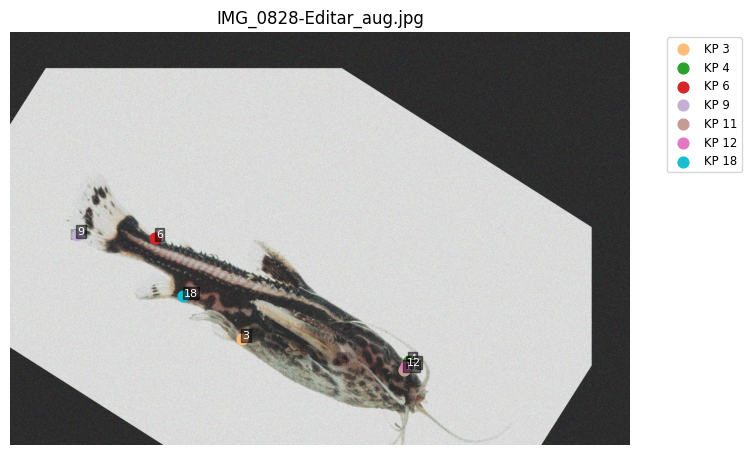

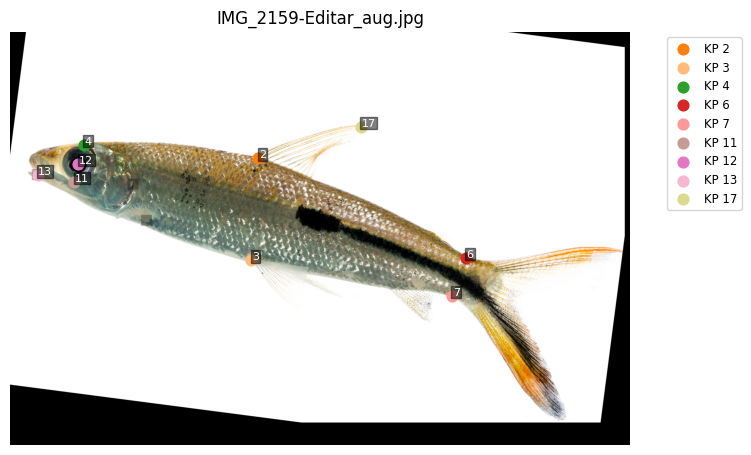

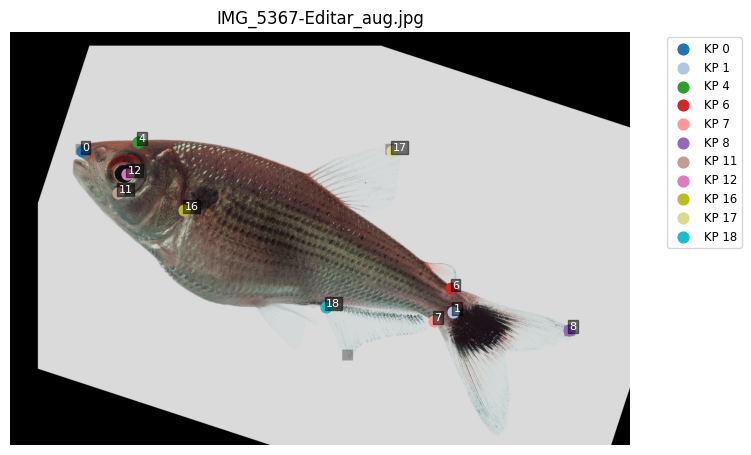

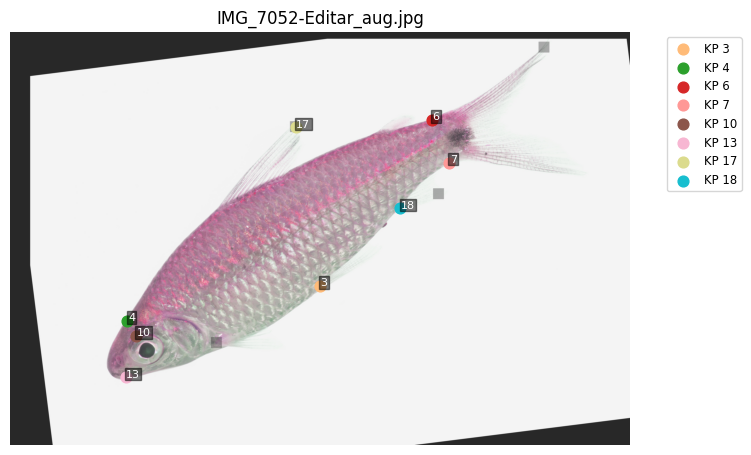

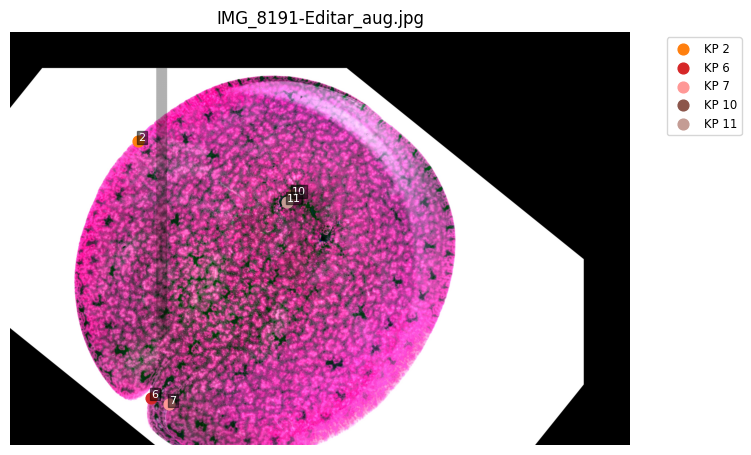

In [63]:
import matplotlib.pyplot as plt
import json
import cv2
import os

# Ruta a la carpeta de salida y JSON generado
OUT_DIR = "/content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation"
ANNOT_JSON_OUT = os.path.join(OUT_DIR, "annotations_aug.json")

# Cargar anotaciones
with open(ANNOT_JSON_OUT, "r") as f:
    coco_aug = json.load(f)

# Crear diccionario img_id -> file_name
img_map = {img["id"]: img["file_name"] for img in coco_aug["images"]}

# Colores para keypoints
COLORS = plt.cm.get_cmap('tab20', 20).colors  # 20 colores distintos

def plot_image_with_keypoints(img_path, keypoints, title=""):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")

    for i in range(20):  # Asumimos 20 keypoints
        x, y, v = keypoints[3 * i: 3 * i + 3]
        if v > 0:  # solo los visibles
            plt.scatter(x, y, c=[COLORS[i]], s=60, label=f"KP {i}")
            plt.text(x + 5, y - 5, str(i), color='white',
                     fontsize=8, bbox=dict(facecolor='black', alpha=0.5, pad=1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()


# 🔁 Visualizar los 5 ejemplos generados
for ann in coco_aug["annotations"]:
    img_id = ann["image_id"]
    file_name = img_map[img_id]
    img_path = os.path.join(OUT_DIR, file_name)
    keypoints = ann["keypoints"]

    plot_image_with_keypoints(img_path, keypoints, title=file_name)






### **SIN Ajuste seguro de rotación y traslación para evitar la pérdida de estructuras morfológicas en peces**

In [8]:

# -------------------------
# CONFIGURACIÓN (EDITABLE)
# -------------------------

# Selección reproducible de 5 imágenes
RANDOM_SEED = 42
N_SAMPLES = 5

# Pares izquierda↔derecha
# Ejemplo :
KP_LR_PAIRS = [
    # (left_idx, right_idx)
    (0, 1)]   # Snout  ↔ caudal fin basin (Standar length) Flip horizontal

# Keypoints difíciles/fáciles (según tu instrucción)
HARD_KP = (1, 3, 15, 19)    # ±10 px
EASY_KP = (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18)    # ±3–5 px

# Ocultar SIEMPRE (v=0) estos kp en train:
HIDE_KP = (1, 3, 15, 19)

# GridMask alrededor de estos kp:
GRIDMASK_TARGETS = (1, 3, 15, 19)
GRIDMASK_PROB = 0.8

# Hidden  kp:
HIDE_PROB_HARD = 0.8
HIDE_PROB_EASY = 0.5
HIDE_PROB_OTHER = 0.1

"""
Esta es la relacion entre pares de KP en funcion de rasgo a medir:

left_idx, right_idx  # (0, 1),   # Snout  ↔ caudal fin basin = (Standar length)
upper_idx, lower_idx # (2, 3),   # Anterior insertion (dorsal fin) ↔ Anterior insertion (pelvic fin) = (Body depth)
upper_idx, lower_idx # (4, 5),   # Dorsal-most (upper) part vertically to the eye ↔ Ventral-most (upper) part vertically to the eye  = (Head depth)
upper_idx, lower_idx # (6, 7),  # Dorsal insertion caudal fin ↔ Ventral insertion caudal fin = (Caudal peduncle depth)
upper_idx, lower_idx # (8, 9),  # Dorsal-most (upper) part vertically to the caudal fin ↔ Ventral-most (upper) part vertically to the caudal fin = (Caudal fin depth)
upper_idx, lower_idx # (10,11),  # Dorsal-most (upper) part of eye ↔ Ventral-most (lower) part of eye = (Eye diameter)
left_idx, right_idx # (12,3),  # Center (centroid) of eye ↔ Anterior insertion of the pelvic fin = (Eye position)
left_idx, right_idx # (0,3),  # Snout ↔ Anterior insertion (pelvic fin) = (Mouth position)
left_idx, right_idx # (0,13),  # Snout ↔ Corner of the mouth = (Maxilary jaw length)
# (14,15),  # Anterior insertion pectoral fin ↔ Distal part the longest ray of the pectoral end = (Pectoral fin legth)
# (14,3),  # Anterior insertion pectoral fin ↔ Anterior insertion (pelvic fin) = (Pectoral fin position)
left_idx, right_idx # (0,16),  # Snout ↔ Most dorsal point of operculum, which is the posterior-most part of the head = (Head length)
# (2,17),  # Anterior insertion (dorsal fin) ↔ Posterior insertion of dorsal fin = (Dorsal-fin length)
# (2,17),  # Anterior insertion of the anal fin ↔ Posterior insertion of the anal fin = (Anal-fin length)


Data augmentation probabilites

Flip horizontal + swap L/R
-Flip horizontal: p = 0.5 (50% de las imágenes).
-Swap L/R: ocurre si y solo si hubo flip (mismo 50%).

Albumentations (geometría + color)

-Shift/Rotate (ShiftScaleRotate): p = 1.0 → siempre.
shift_limit=0.10 (±10%), rotate_limit=45°, scale_limit=0.0 (sin escalado), relleno negro en bordes.
-GaussNoise: p = 0.25 → 25% de las imágenes.
-ColorJitter: p = 0.7 → 70% de las imágenes.

GridMask local alrededor de ciertos keypoints
-Para cada kp objetivo se aplica con probabilidad GRIDMASK_PROB = 0.2 (20%), independiente por kp.
n = 4 intentos (uno por cada kp objetivo)
p = 0.8 → 80% de probabilidad de aplicar GridMask en cada kp
Lo más probable es que se apliquen 3 o 4 regiones por imagen (cada uno con ~41% de probabilidad).
Que haya solo 1 región es raro (~2.5%) y que no haya ninguna es casi imposible (~0.16%)

Visibilidad y jitter de keypoints
-Ocultar (poner v=0) siempre para HIDE_KP = (1, 3, 15, 19) → 100% (es determinista).
Jitter de keypoints visibles: para cada kp con v>0, p_apply = 0.8 (80%) de desplazarlo:
Si i ∈ HARD_KP: desplazamiento aleatorio entero en [-10,10] px en x e y.
Si i ∈ EASY_KP: desplazamiento aleatorio en [-m, m] con m ∈ {3,4,5} px.
Si no está en ninguna de las listas: desplazamiento en [-3,3] px.
Los cuatro kp ocultos no reciben jitter (porque v se pone a 0 antes del jitter).
"""


# -------------------------
# UTILIDADES
# -------------------------
def load_coco_annotations(json_path):
    """Carga COCO JSON y retorna mapas: img_id->meta, file_name->img_id, img_id->ann (20 kp)."""
    with open(json_path, "r") as f:
        coco = json.load(f)

    images = {img["id"]: img for img in coco["images"]}
    by_file = {Path(img["file_name"]).name: img["id"] for img in coco["images"]}

    # asumimos 1 anotación por imagen con 20 kp
    anns_by_img = {}
    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        anns_by_img[img_id] = ann

    return images, by_file, anns_by_img, coco


def list_images_recursive(root):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG", "*.JPEG")
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return files

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

# -------------------------
# TRANSFORMACIONES
# -------------------------

# Image manipulation

## Geometric manipulation + Non-Geometric

# Geometría + fotometría (sin flips verticales)
train_geom_and_color = A.Compose(
    [
        A.ShiftScaleRotate(
            shift_limit=0.10,  # traslación ±10% (Geometric manipulation)
            scale_limit=0.0,   # sin escalado, mismo tamaño
            rotate_limit=45,   # ±45° (Geometric manipulation)
            border_mode=cv2.BORDER_CONSTANT, # píxeles fuera de bordes se rellenan con valor fijo
            value=(0, 0, 0), # fondo negro al rotar o trasladar
            p=1.0 # probabilidad 100%, se aplica siempre
        ),
        A.GaussNoise(var_limit=(5.0, 25.0), p=0.25), #(Non -Geometric) Añade ruido gaussiano suave con varianza aleatoria entre 5 y 25 (se aplica 25% de probabilidad)
        A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.7 #(Non -Geometric) Alteraciones de color (aplica con 70% de probabilidad)
        ),
    ],
    keypoint_params=A.KeypointParams(
        format='xy', remove_invisible=False, label_fields=['keypoints_vis']
    )
)

"""
keypoints_vis que contiene un valor de visibilidad para cada keypoint.
v = 2: el keypoint es visible
v = 1: el keypoint existe pero no es visible (no lo usamos aquí)
v = 0: el keypoint está oculto o no es relevante, el modelo no será penalizado si no lo predice bien

remove_invisible=False: No elimina los keypoints si salen de la imagen, los conserva
la visibilidad de los keypoints se respete si están ocultos
"""

# Non_geometric

def hflip_with_swap(image, keypoints_xyv, kp_lr_pairs=None, p=0.5, swap=False):
    """
    Flip horizontal con prob. p.
    - Siempre actualiza x: x' = (w - 1) - x
    - Si swap=True y hay kp_lr_pairs: intercambia pares L/R
    Devuelve: (imagen_flipped, keypoints_flipped, did_flip)
    """
    if random.random() > p:
        return image, list(keypoints_xyv), False

    img = cv2.flip(image, 1)  # flip horizontal
    h, w = img.shape[:2]

    # Actualiza coordenadas (x) y conserva y, v
    kps = []
    for (x, y, v) in keypoints_xyv:
        x_new = float((w - 1) - float(x))
        kps.append((x_new, float(y), int(v)))

    # Opcional: swap L/R para mantener semántica por índice
    if swap and kp_lr_pairs:
        kps = list(kps)  # asegurar mutabilidad
        for (li, ri) in kp_lr_pairs:
            if 0 <= li < len(kps) and 0 <= ri < len(kps):
                kps[li], kps[ri] = kps[ri], kps[li]

    return img, kps, True


def apply_local_gridmask(
    image,
    keypoints_xy,              # [(x,y), ...]
    kp_indices_to_occlude,
    box_size=96,
    grid_d=32,
    ratio=0.5,
    prob=0.2,
    angle_deg=0
):
    """Aplica GridMask SOLO en cajas centradas en kp objetivo."""
    h, w = image.shape[:2]
    img = image.copy()

    for idx in kp_indices_to_occlude:
        if idx < 0 or idx >= len(keypoints_xy):
            continue
        if random.random() > prob:
            continue

        cx, cy = int(keypoints_xy[idx][0]), int(keypoints_xy[idx][1])
        half = box_size // 2
        x1 = max(0, cx - half); y1 = max(0, cy - half)
        x2 = min(w, cx + half); y2 = min(h, cy + half)

        region = img[y1:y2, x1:x2]
        rh, rw = region.shape[:2]
        if rh <= 1 or rw <= 1:
            continue

        mask = np.ones((rh, rw), dtype=np.uint8)
        for y in range(0, rh, grid_d):
            band = int(max(1, ratio * grid_d))
            y_end = min(rh, y + band)
            mask[y:y_end, :] = 0
        for x in range(0, rw, grid_d):
            band = int(max(1, ratio * grid_d))
            x_end = min(rw, x + band)
            mask[:, x:x_end] = 0

        if angle_deg != 0:
            M = cv2.getRotationMatrix2D((rw / 2, rh / 2), angle_deg, 1.0)
            mask = cv2.warpAffine(mask, M, (rw, rh), flags=cv2.INTER_NEAREST, borderValue=1)

        region[mask == 0] = 0
        img[y1:y2, x1:x2] = region

    return img


def jitter_keypoints_xyv(
    keypoints_xyv,
    img_w, img_h,
    hard_indices=HARD_KP,
    easy_indices=EASY_KP,
    p_apply=0.8
):
    out = []
    for i, (x, y, v) in enumerate(keypoints_xyv):
        if v > 0 and random.random() < p_apply:
            if i in hard_indices:
                dx = random.randint(-10, 10)
                dy = random.randint(-10, 10)
            elif i in easy_indices:
                mag = random.randint(3, 5)
                dx = random.randint(-mag, mag)
                dy = random.randint(-mag, mag)
            else:
                dx = random.randint(-3, 3)
                dy = random.randint(-3, 3)
            x = np.clip(x + dx, 0, img_w - 1)
            y = np.clip(y + dy, 0, img_h - 1)
        out.append((float(x), float(y), int(v)))
    return out


def hide_keypoints_xyv_by_difficulty(
    keypoints_xyv,
    hard_indices=HARD_KP,
    easy_indices=EASY_KP,
    p_hard=HIDE_PROB_HARD,
    p_easy=HIDE_PROB_EASY,
    p_other=HIDE_PROB_OTHER,
    rng=None
):
    if rng is None:
        rng = random
    hard_set = set(hard_indices)
    easy_set = set(easy_indices)
    out = []
    for i, (x, y, v) in enumerate(keypoints_xyv):
        if i in hard_set:
            p = p_hard
        elif i in easy_set:
            p = p_easy
        else:
            p = p_other
        if rng.random() < p:
            out.append((float(x), float(y), 0))
        else:
            out.append((float(x), float(y), int(v)))
    return out


def augment_sample(image_bgr, keypoints_xyv):
    """
    Orden:
      1) Flip H + swap L/R (p=0.5)
      2) Geometría (rot, trans) + fotometría (ruido + color)
      3) GridMask local cerca de kp
      4) Ocultar (v=0) -> Jitter visible
    """
    # 1) Flip H + swap L/R
    img_aug, kps_xyv, did_flip = hflip_with_swap(
        image_bgr, keypoints_xyv, KP_LR_PAIRS, p=0.5, swap=False
    )

    # 2) Geometría + fotometría (albumentations)
    keypoints_xy = [(x, y) for (x, y, v) in kps_xyv]
    keypoints_vis = [int(v) for (_, _, v) in kps_xyv]

    transformed = train_geom_and_color(
        image=img_aug,
        keypoints=keypoints_xy,
        keypoints_vis=keypoints_vis
    )
    img_aug = transformed['image']
    kps_aug_xy = transformed['keypoints']
    kps_aug_vis = transformed['keypoints_vis']
    kps_aug_xyv = [(float(x), float(y), int(v)) for (x, y), v in zip(kps_aug_xy, kps_aug_vis)]

    # 3) GridMask local
    img_aug = apply_local_gridmask(
        img_aug,
        keypoints_xy=[(x, y) for (x, y, v) in kps_aug_xyv],
        kp_indices_to_occlude=GRIDMASK_TARGETS,
        box_size=96, grid_d=32, ratio=0.2,
        prob=GRIDMASK_PROB, angle_deg=4
    )

    # 4) Ocultar -> Jitter
    h, w = img_aug.shape[:2]
    kps_aug_xyv = hide_keypoints_xyv_by_difficulty(kps_aug_xyv)
    kps_aug_xyv = jitter_keypoints_xyv(kps_aug_xyv, img_w=w, img_h=h)

    return img_aug, kps_aug_xyv



/tmp/ipython-input-3996257741.py:121: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3996257741.py:129: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 25.0), p=0.25), #(Non -Geometric) Añade ruido gaussiano suave con varianza aleatoria entre 5 y 25 (se aplica 25% de probabilidad)


In [ ]:
# -------------------------
# PIPELINE PRINCIPAL (5 imágenes)
# -------------------------
def main():
    ensure_dir(OUT_DIR)
    images_meta, by_file, anns_by_img, coco = load_coco_annotations(ANNOT_JSON)

    # Lista de imágenes (recursivo) y selección reproducible
    all_imgs = list_images_recursive(IMAGES_ROOT)
    if len(all_imgs) == 0:
        raise RuntimeError(f"No se encontraron imágenes en {IMAGES_ROOT}")
    random.seed(RANDOM_SEED)
    subset = sorted(random.sample(all_imgs, k=min(N_SAMPLES, len(all_imgs))))

    out_coco = {
        "images": [],
        "annotations": [],
        "categories": coco.get("categories", [])
    }
    ann_id = 1

    for img_path in subset:
        img = cv2.imread(img_path)
        if img is None:
            print(f"[WARN] No se pudo leer: {img_path}")
            continue

        base = Path(img_path).name
        # Buscar por basename en COCO
        if base not in by_file:
            print(f"[WARN] {base} no está en anotaciones (se omite).")
            continue
        img_id = by_file[base]
        if img_id not in anns_by_img:
            print(f"[WARN] {base} sin annotation (se omite).")
            continue

        ann = anns_by_img[img_id]
        # COCO 'keypoints' = [x1,y1,v1,...,x20,y20,v20]
        kp = ann["keypoints"]
        if len(kp) != 20 * 3:
            print(f"[WARN] {base} con {len(kp)} valores de kp (esperado 60).")
            continue
        keypoints_xyv = [(float(kp[3*i]), float(kp[3*i+1]), int(kp[3*i+2])) for i in range(20)]

        # Aumentar
        img_aug, kps_aug_xyv = augment_sample(img, keypoints_xyv)

        # Guardar imagen
        out_name = f"{Path(base).stem}_aug.jpg"
        out_path = os.path.join(OUT_DIR, out_name)
        cv2.imwrite(out_path, img_aug)

        h2, w2 = img_aug.shape[:2]
        out_img_id = int(img_id)  # puedes crear nuevos ids si prefieres

        out_coco["images"].append({
            "id": out_img_id,
            "file_name": out_name,
            "width": w2,
            "height": h2
        })

        flat_kp = []
        visible_count = 0
        for (x, y, v) in kps_aug_xyv:
            flat_kp.extend([float(x), float(y), int(v)])
            if v > 0:
                visible_count += 1

        out_coco["annotations"].append({
            "id": ann_id,
            "image_id": out_img_id,
            "category_id": ann.get("category_id", 1),
            "keypoints": flat_kp,
            "num_keypoints": 20,
            "iscrowd": 0,
            "bbox": ann.get("bbox", [0,0,w2,h2]),   # opcional
            "area": ann.get("area", float(w2*h2))   # opcional
        })
        ann_id += 1

        print(f"[OK] Guardado: {out_path}")

    # Guardar JSON de salida
    out_json = os.path.join(OUT_DIR, "annotations_aug.json")
    with open(out_json, "w") as f:
        json.dump(out_coco, f, indent=2)
    print(f"[OK] Anotaciones guardadas en: {out_json}")


if __name__ == "__main__":
    main()


/tmp/ipython-input-1104642366.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLORS = plt.cm.get_cmap('tab20', 20).colors  # 20 colores distintos


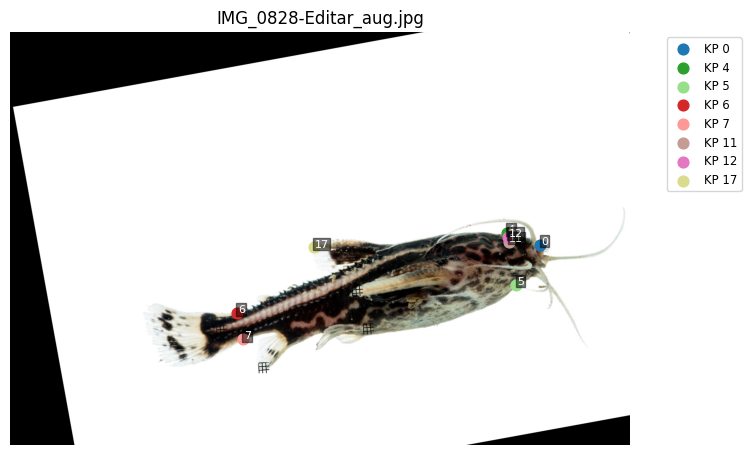

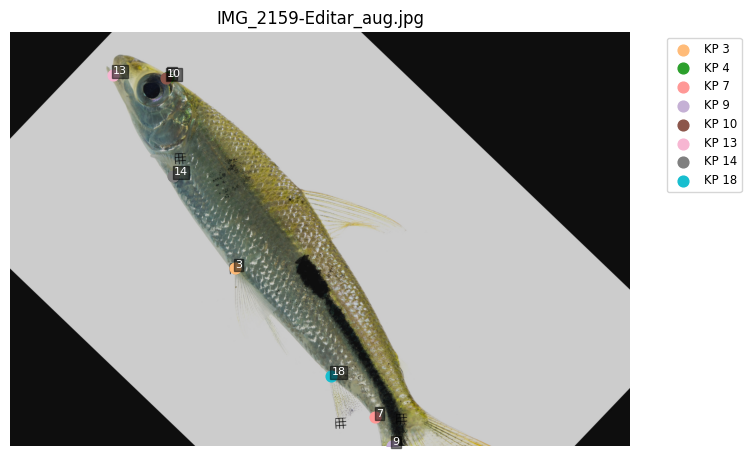

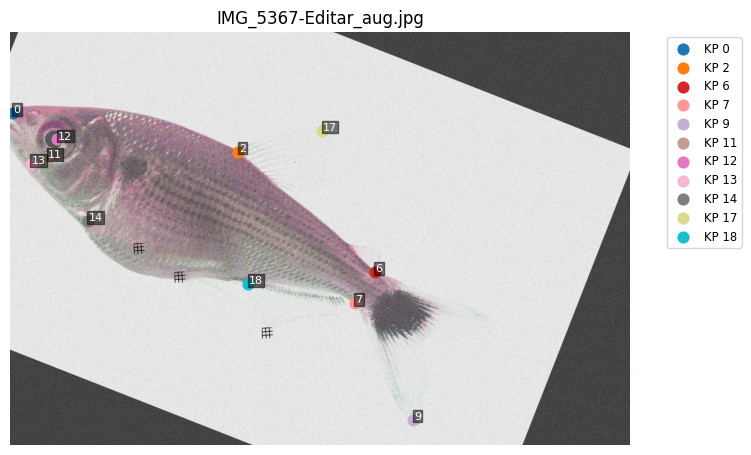

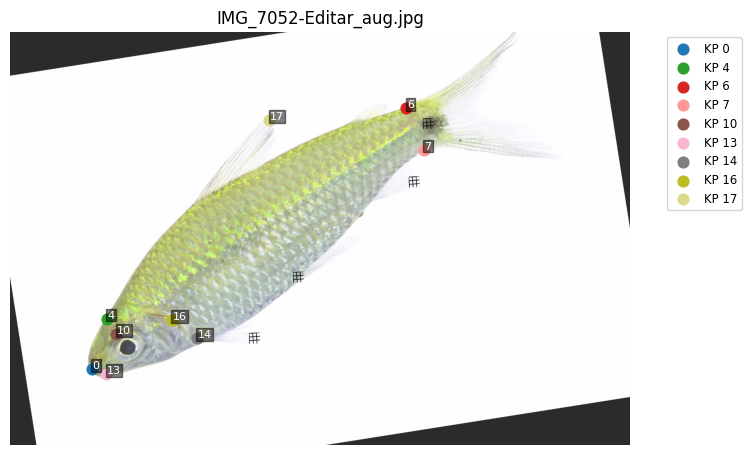

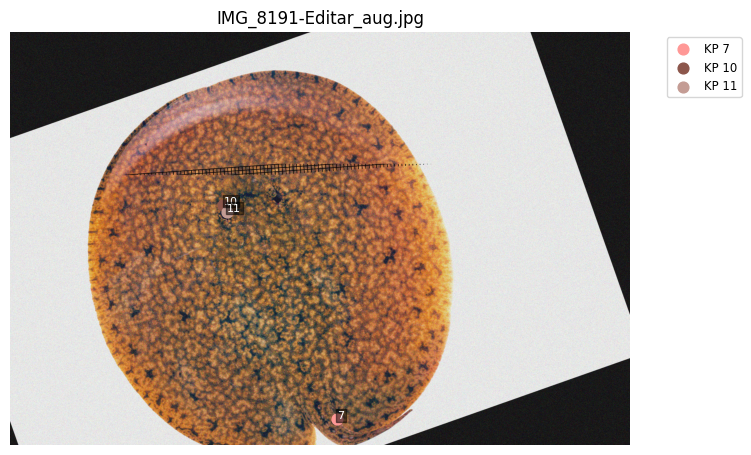

In [9]:
import matplotlib.pyplot as plt
import json
import cv2
import os

# Ruta a la carpeta de salida y JSON generado
OUT_DIR = "/content/drive/MyDrive/POSGRADO/ DOCTORADO UIS/PRODUCTOS DOCTORADO/2. Keypoints_fish/Code/VitPose/Data augmentation"
ANNOT_JSON_OUT = os.path.join(OUT_DIR, "annotations_aug.json")

# Cargar anotaciones
with open(ANNOT_JSON_OUT, "r") as f:
    coco_aug = json.load(f)

# Crear diccionario img_id -> file_name
img_map = {img["id"]: img["file_name"] for img in coco_aug["images"]}

# Colores para keypoints
COLORS = plt.cm.get_cmap('tab20', 20).colors  # 20 colores distintos

def plot_image_with_keypoints(img_path, keypoints, title=""):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")

    for i in range(20):  # Asumimos 20 keypoints
        x, y, v = keypoints[3 * i: 3 * i + 3]
        if v > 0:  # solo los visibles
            plt.scatter(x, y, c=[COLORS[i]], s=60, label=f"KP {i}")
            plt.text(x + 5, y - 5, str(i), color='white',
                     fontsize=8, bbox=dict(facecolor='black', alpha=0.5, pad=1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()


# 🔁 Visualizar los 5 ejemplos generados
for ann in coco_aug["annotations"]:
    img_id = ann["image_id"]
    file_name = img_map[img_id]
    img_path = os.path.join(OUT_DIR, file_name)
    keypoints = ann["keypoints"]

    plot_image_with_keypoints(img_path, keypoints, title=file_name)




